# Importing Important Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers


In [2]:
Batch_Size = 32 # 32 images in 1 batch
Channels = 3  # RGB
Image_Size = 256  # 256x256
Epoches = 50  # for training purpose


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "IMAGES",
    batch_size=Batch_Size,
    shuffle=True,
    image_size=(Image_Size, Image_Size)
)


Found 4217 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
for class_name in class_names:
    print(class_name)


cataract
diabetic_retinopathy
glaucoma
normal


# IMAGE VISUALIZATION

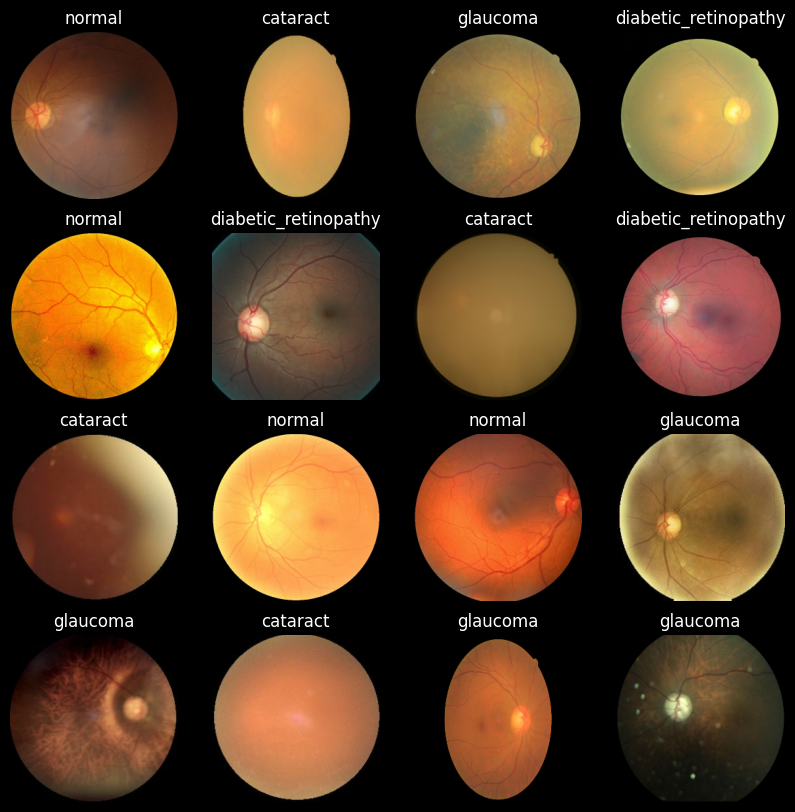

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [6]:

len(dataset)  # number of epoches


132

# Train Test Split

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=2000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
# sum should be equal to epoche size or number of batches


105
13
14


# Cache, Shuffle, and Prefetch the Dataset


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1./255),
])


# DATA AGUMENTATION
#### Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),  # Add random contrast adjustment
  layers.experimental.preprocessing.RandomZoom(0.2),      # Add random zoom
])


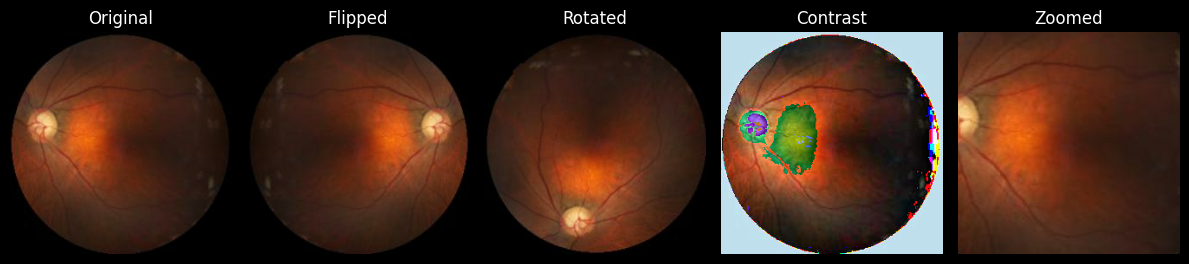

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Select a single image from the dataset
image_index = 1
image = next(iter(train_ds.unbatch().skip(image_index).take(1)))[0]

# Apply different augmentations to the image
flipped_image = tf.image.flip_left_right(image)
rotated_image = tf.image.rot90(image)
contrast_image = tf.image.adjust_contrast(image, 2)  # Increase contrast
zoomed_image = tf.image.central_crop(image, 0.7)     # Zoom into the image

# Plot the original and augmented images
plt.figure(figsize=(12, 4))
titles = ["Original", "Flipped", "Rotated", "Contrast", "Zoomed"]
images = [image, flipped_image, rotated_image, contrast_image, zoomed_image]

for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.title(titles[i], fontsize=12)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()


# VGGNET

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define VGG-style CNN architecture
def create_vgg_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Block 1
    x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 2
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 3
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 4
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 5
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Block 6
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name='vgg_like')
    return model

# Define input shape and number of classes
input_shape = (Image_Size ,Image_Size, Channels)  # Update the input shape here
num_classes = 4

# Create VGG-like model
vgg_like_model = create_vgg_model(input_shape, num_classes)

# Compile the model
vgg_like_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
vgg_like_model.summary()


Model: "vgg_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        369

In [15]:
vgg_like_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with early stopping
history = vgg_like_model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=Epoches,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback to the fit method
)


Epoch 1/50
105/105 [==============================] - 428s 4s/step - loss: 1.3108 - accuracy: 0.5771 - val_loss: 0.7769 - val_accuracy: 0.6466
Epoch 2/50
105/105 [==============================] - 368s 4s/step - loss: 0.6316 - accuracy: 0.7486 - val_loss: 0.5018 - val_accuracy: 0.8149
Epoch 3/50
105/105 [==============================] - 379s 4s/step - loss: 0.5281 - accuracy: 0.7921 - val_loss: 0.4455 - val_accuracy: 0.8125
Epoch 4/50
105/105 [==============================] - 403s 4s/step - loss: 0.4508 - accuracy: 0.8228 - val_loss: 0.3546 - val_accuracy: 0.8486
Epoch 5/50
105/105 [==============================] - 370s 4s/step - loss: 0.4266 - accuracy: 0.8270 - val_loss: 0.3473 - val_accuracy: 0.8389
Epoch 6/50
105/105 [==============================] - 368s 4s/step - loss: 0.4029 - accuracy: 0.8369 - val_loss: 0.3262 - val_accuracy: 0.8558
Epoch 7/50
105/105 [==============================] - 371s 4s/step - loss: 0.4107 - accuracy: 0.8345 - val_loss: 0.3322 - val_accuracy: 0.8750

# Confusion Matrix and other important parameters

14/14 [==============================] - 36s 438ms/step - loss: 0.1651 - accuracy: 0.9442
Test Accuracy: 0.9441964030265808
14/14 [==============================] - 8s 444ms/step
F1 Score: 0.32627518050044096
Recall: 0.32589285714285715
Precision: 0.3269146868452641


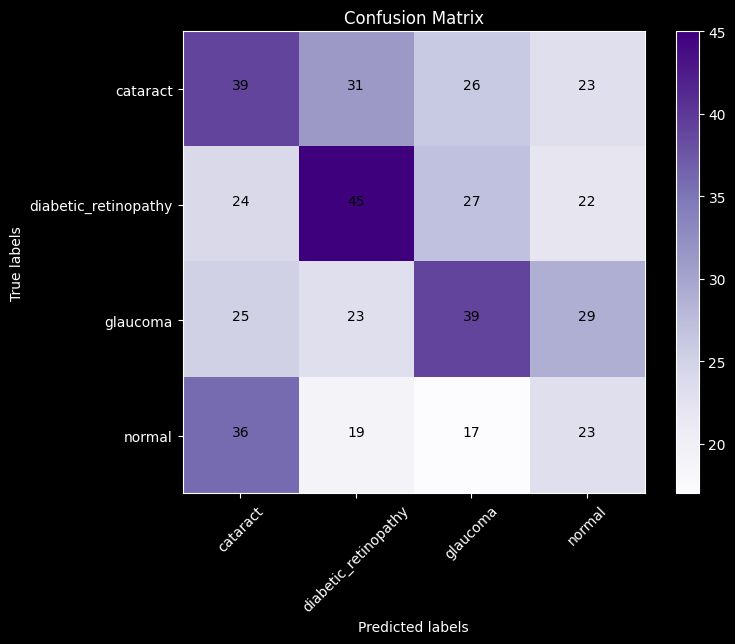

In [17]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

# Evaluate the model on the test dataset
test_loss, test_accuracy = vgg_like_model.evaluate(test_ds)

print("Test Accuracy:", test_accuracy)

# Predict labels for the test dataset
predictions = vgg_like_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels for the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Compute additional metrics
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix , cmap=plt.cm.Purples)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="black")

plt.title("Confusion Matrix")
plt.show()


In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Ploting Model Accuracy and loss curves 

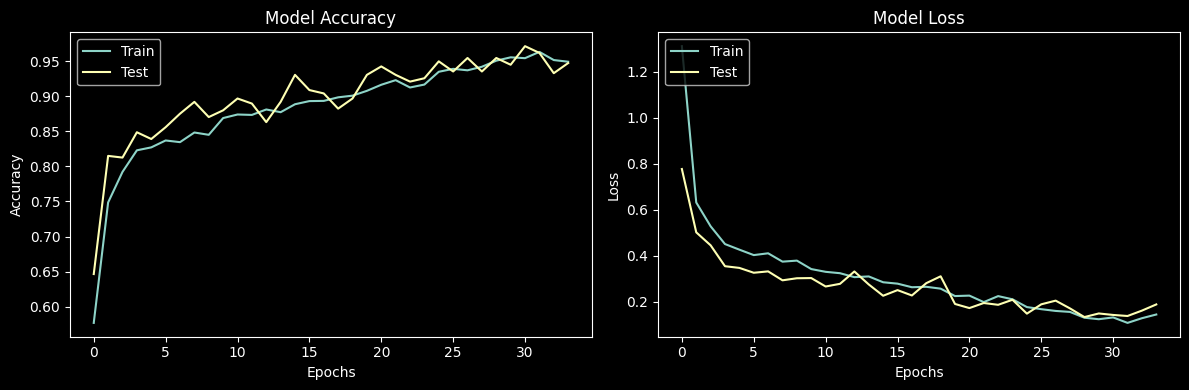

In [22]:
import matplotlib.pyplot as plt

# Plotting model accuracy and loss for both training and test data
plt.figure(figsize=(12, 4))

# Plotting model accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  # Adding validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  # Adding validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


# Testing The Model

first image to predict
actual label: cataract
1/1 [==============================] - 1s 840ms/step
predicted label: cataract


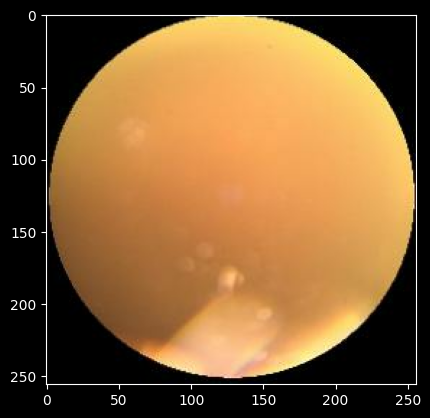

In [19]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = vgg_like_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 77ms/step


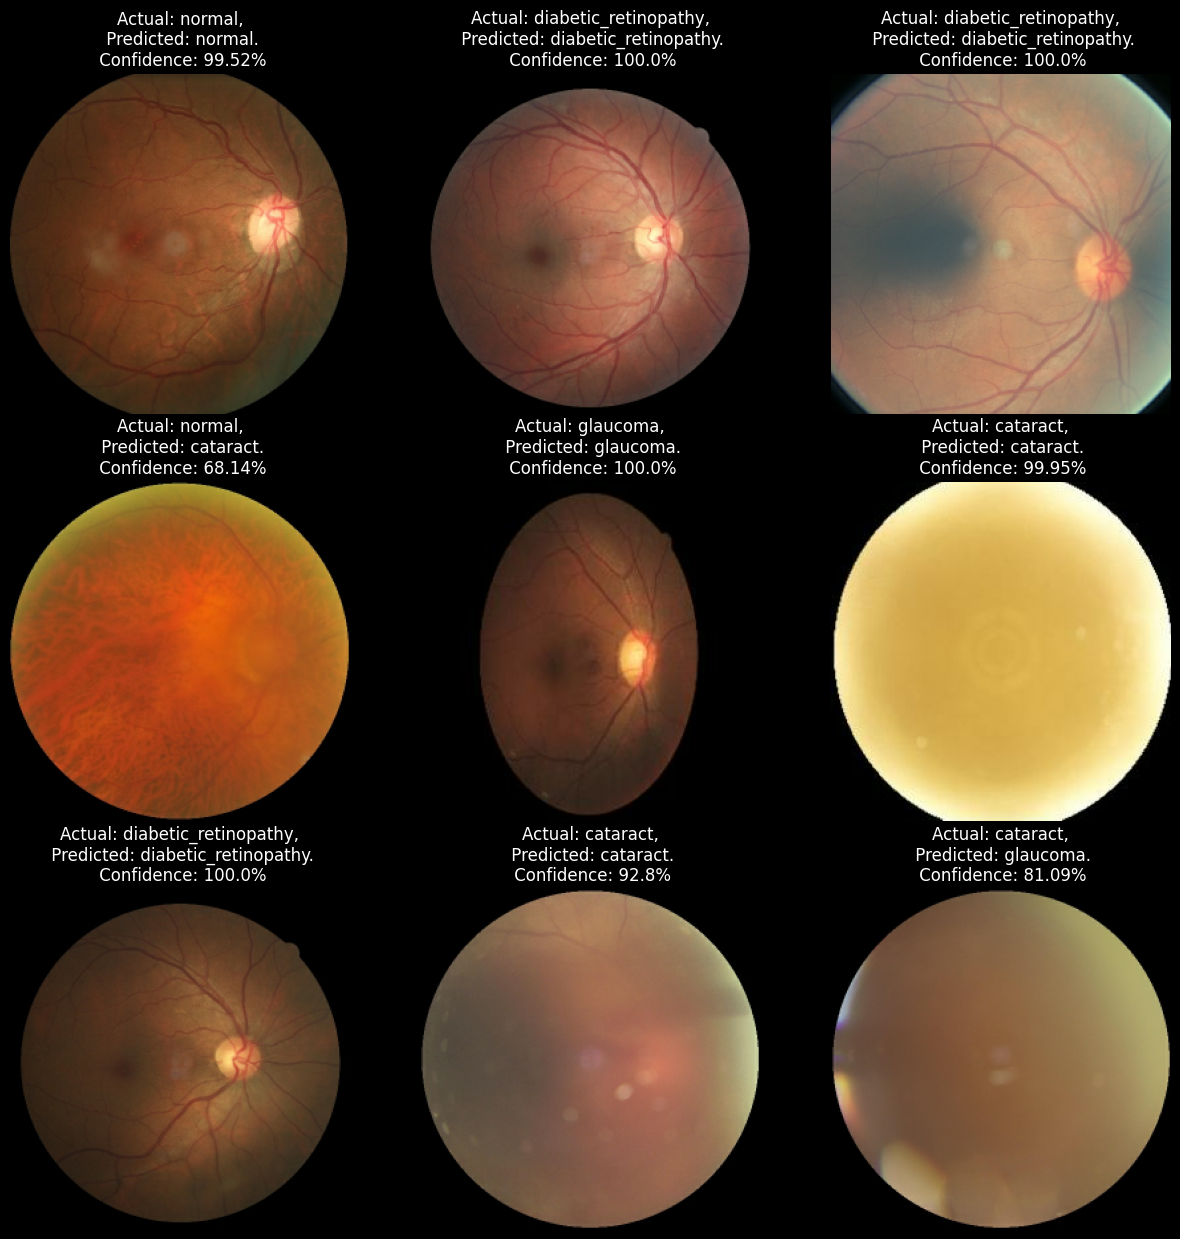

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(vgg_like_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")